In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive, widgets
from IPython.display import display
import json


In [2]:
def load_graph(edge_list_path):
    G = nx.read_edgelist(edge_list_path, nodetype=int)
    return G

# Step 2: Load mutation data
def load_mutations(mutation_data_path):
    mutations_df = pd.read_csv(mutation_data_path, sep="\t", header=None)
    return mutations_df

# Establish a consistent color map for mutations
def create_color_map(mutations_df):
    all_mutations = pd.unique(mutations_df.values.ravel())
    unique_mutations = all_mutations[~np.isnan(all_mutations)]  # Remove NaN values if present
    color_palette = plt.cm.tab20(np.linspace(0, 1, len(unique_mutations)))
    color_map = {mutation: color_palette[i] for i, mutation in enumerate(unique_mutations)}
    return color_map

# Adjust the plot_graph function to correctly handle the node colors
def plot_graph(G, pos, mutations_df, name, color_map, time_step):
    plt.figure(figsize=(10, 8))
    mutations_at_step = mutations_df.iloc[time_step].dropna()  # Drop NaN values for the current time step
    
    # Ensure node list from graph G matches the indices in mutations_df
    node_list = [str(node) for node in G.nodes()]  # Convert node IDs to strings if necessary
    mutations_sub = [mutations_at_step.get(int(node), np.nan) for node in node_list]
    node_colors_sub = [color_map.get(mutation, (1, 1, 1)) for mutation in mutations_sub]
    
    # if "geo" in name:
    #     pos = nx.get_node_attributes(G, 'pos')
    #     print(pos)
    # else:
    #     pos = nx.kamada_kawai_layout(G) # Use spring layout for node positions
    nx.draw(G, pos, node_color=node_colors_sub, with_labels=False, edge_color='gray')
    plt.title(f'{name} at time step: {time_step}')
    plt.show()


In [3]:

# Define the list of graphs
graph_options = ["3-r", "5-r", "bipartite_10", "bipartite_30", "bipartite_50", "detour_10", 
                 "detour_30", "detour_50", "detour_70", "detour_90", "geo_0.1", "geo_0.15", 
                 "geo_0.2", "geo_0.25", "PA", "star", "wheel", "wm"]

# Define the list of mu and s values
mus = [0.1, 0.01, 0.001, 0.0001, 0.00001]
ss = [1, 0.1, 0.01, 0.001, -0.001, -0.01, -0.1, -1]

# Define the interactive widgets for graph 1
graph_dropdown_1 = widgets.Dropdown(options=graph_options, description='Graph 1:')
mu_slider_1 = widgets.SelectionSlider(options=mus, description='mu 1:')
s_slider_1 = widgets.SelectionSlider(options=ss, description='s 1:')
time_step_slider = widgets.IntSlider(min=0, max=1999, step=1, value=0, description='Time Step')

# Define the interactive widgets for graph 2
graph_dropdown_2 = widgets.Dropdown(options=graph_options, description='Graph 2:')
mu_slider_2 = widgets.SelectionSlider(options=mus, description='mu 2:')
s_slider_2 = widgets.SelectionSlider(options=ss, description='s 2:')
# time_step_slider2 = widgets.IntSlider(min=0, max=1999, step=1, value=0, description='Time Step 2')

# def on_time_step_change(change):
#     time_step_slider2.value = change.new

# time_step_slider.observe(on_time_step_change, names='value')

# Define the function to update graph 1
def update_plot_1(graph, mu, s, time_step):
    edge_path = f'graphs/{graph}.txt'
    G = nx.read_edgelist(edge_path, nodetype=int)
    if 'geo' in graph:
        with open(f'graphs/{graph}_nodes.json', 'r') as f:
            pos = json.load(f)
        pos = {int(node): position for node, position in pos.items()}
    else:
        pos = nx.kamada_kawai_layout(G)
    mutations_df = load_mutations(f'output/{graph}/{mu}_{s}_clone.txt')
    color_map = create_color_map(mutations_df)
    plot_graph(G, pos, mutations_df, f"{graph} - mu={mu} - s={s}", color_map, time_step)

# Define the function to update graph 2
def update_plot_2(graph, mu, s, time_step):
    edge_path = f'graphs/{graph}.txt'
    G = nx.read_edgelist(edge_path, nodetype=int)
    if 'geo' in graph:
        with open(f'graphs/{graph}_nodes.json', 'r') as f:
            pos = json.load(f)
        pos = {int(node): position for node, position in pos.items()}
    else:
        pos = nx.kamada_kawai_layout(G)
    mutations_df = load_mutations(f'output/{graph}/{mu}_{s}_clone.txt')
    color_map = create_color_map(mutations_df)
    plot_graph(G, pos, mutations_df, f"{graph} - mu = {mu} - s={s}", color_map, time_step)

# Create the interactive plots
interactive_plot_1 = widgets.interactive(update_plot_1, graph=graph_dropdown_1, mu=mu_slider_1, s=s_slider_1, time_step=time_step_slider)
interactive_plot_2 = widgets.interactive(update_plot_2, graph=graph_dropdown_2, mu=mu_slider_2, s=s_slider_2, time_step=time_step_slider)

# Display the interactive plots side by side
display(widgets.HBox([interactive_plot_1, interactive_plot_2]))

In [4]:
def build_tree(file_path):
    G = nx.DiGraph()  
    with open(file_path, 'r') as file:
        parent_ids = list(map(int, file.readline().strip().split('\t')))
    
    for child_id, parent_id in enumerate(parent_ids, start=1):
        G.add_edge(parent_id, child_id)
    
    return G

def get_depth(node_id, G):
    return nx.shortest_path_length(G, source=0, target=node_id)

def create_color_map_depth(mutations_df, tree):
    all_mutations = pd.unique(mutations_df.values.ravel())
    unique_mutations = all_mutations[~np.isnan(all_mutations)]
    mutation_depths = {mutation: nx.shortest_path_length(tree, source=0, target=mutation) for mutation in unique_mutations if mutation in tree.nodes}

    unique_depths = np.unique(list(mutation_depths.values()))
    color_palette = plt.cm.viridis_r(np.linspace(0, 1, len(unique_depths)))
    depth_color_map = {depth: color_palette[i] for i, depth in enumerate(unique_depths)}

    color_map = {mutation: depth_color_map[mutation_depths[mutation]] for mutation in unique_mutations if mutation in mutation_depths}
    
    return color_map, depth_color_map

def create_color_map_distance(mutations_df, tree):
    all_mutations = pd.unique(mutations_df.values.ravel())
    unique_mutations = all_mutations[~np.isnan(all_mutations)]
    mutation_depths = {mutation: nx.shortest_path_length(tree, source=0, target=mutation) for mutation in unique_mutations if mutation in tree.nodes}

    unique_depths = np.unique(list(mutation_depths.values()))
    color_palette = plt.cm.viridis_r(np.linspace(0, 1, len(unique_depths)))
    depth_color_map = {depth: color_palette[i] for i, depth in enumerate(unique_depths)}

    color_map = {mutation: depth_color_map[mutation_depths[mutation]] for mutation in unique_mutations if mutation in mutation_depths}
    
    return color_map, depth_color_map

def plot_graph_depth(G, pos, mutations_df, title, color_map, depth_color_map, time_step):
    fig, ax = plt.subplots(figsize=(10, 8))
    # plt.figure(figsize=(10, 8))
    mutations_at_step = mutations_df.iloc[time_step].dropna()  # Drop NaN values for the current time step
    
    # Ensure node list from graph G matches the indices in mutations_df
    node_list = [str(node) for node in G.nodes()]  # Convert node IDs to strings if necessary
    mutations_sub = [mutations_at_step.get(int(node), np.nan) for node in node_list]
    node_colors_sub = [color_map.get(mutation, (1, 1, 1)) for mutation in mutations_sub]
    nx.draw(G, pos, node_color=node_colors_sub, with_labels=False, edge_color='gray', ax = ax)
    
    # Create custom legend
    unique_depths = list(depth_color_map.keys())
    norm = plt.Normalize(min(unique_depths), max(unique_depths))
    cmap = plt.cm.viridis_r  # or any other colormap
    
    # Create a ScalarMappable and initialize a data array for the color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    # Add color bar to the plot
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Mutation Depth')
    
    # # Optional: Set the color bar to map to the depth values explicitly
    # cbar.set_ticks(np.linspace(min(unique_depths), max(unique_depths), len(unique_depths)))
    # cbar.set_ticklabels(unique_depths)
    
    plt.title(title)
    plt.show()

In [13]:

# Define the list of graphs
graph_options = ["3-r", "5-r", "bipartite_10", "bipartite_30", "bipartite_50", "detour_10", 
                 "detour_30", "detour_50", "detour_70", "detour_90", "geo_0.1", "geo_0.15", 
                 "geo_0.2", "geo_0.25", "PA", "star", "wheel", "wm"]

# Define the list of mu and s values
mus = [0.1, 0.01, 0.001, 0.0001, 0.00001]
ss = [1, 0.1, 0.01, 0.001, 0, -0.001, -0.01, -0.1, -1]

graph_dropdown_1 = widgets.Dropdown(options=graph_options, description='Graph 1:')
mu_slider_1 = widgets.SelectionSlider(options=mus, description='mu 1:')
s_slider_1 = widgets.SelectionSlider(options=ss, description='s 1:')
time_step_slider = widgets.IntSlider(min=0, max=1999, step=1, value=0, description='Time Step')

graph_dropdown_2 = widgets.Dropdown(options=graph_options, description='Graph 2:')
mu_slider_2 = widgets.SelectionSlider(options=mus, description='mu 2:')
s_slider_2 = widgets.SelectionSlider(options=ss, description='s 2:')


def update_plot_1(graph, mu, s, time_step):
    edge_path = f'graphs/{graph}.txt'
    G = nx.read_edgelist(edge_path, nodetype=int)
    if 'geo' in graph:
        with open(f'graphs/{graph}_nodes.json', 'r') as f:
            pos = json.load(f)
        pos = {int(node): position for node, position in pos.items()}
    else:
        pos = nx.kamada_kawai_layout(G)
    mutations_df = load_mutations(f'output/{graph}/{mu}_{s}_clone.txt')
    tree = build_tree(f'output/{graph}/{mu}_{s}_tree.txt')
    color_map, depth_color_map = create_color_map_depth(mutations_df, tree)
    plot_graph_depth(G, pos, mutations_df, f"{graph} - mu={mu} - s={s}", color_map, depth_color_map, time_step)

# Define the function to update graph 2
def update_plot_2(graph, mu, s, time_step):
    edge_path = f'graphs/{graph}.txt'
    G = nx.read_edgelist(edge_path, nodetype=int)
    if 'geo' in graph:
        with open(f'graphs/{graph}_nodes.json', 'r') as f:
            pos = json.load(f)
        pos = {int(node): position for node, position in pos.items()}
    else:
        pos = nx.kamada_kawai_layout(G)
    mutations_df = load_mutations(f'output/{graph}/{mu}_{s}_clone.txt')
    tree = build_tree(f'output/{graph}/{mu}_{s}_tree.txt')
    color_map, depth_color_map = create_color_map_depth(mutations_df, tree)
    plot_graph_depth(G, pos, mutations_df, f"{graph} - mu={mu} - s={s}", color_map, depth_color_map, time_step)

# Create the interactive plots
interactive_plot_1 = widgets.interactive(update_plot_1, graph=graph_dropdown_1, mu=mu_slider_1, s=s_slider_1, time_step=time_step_slider)
interactive_plot_2 = widgets.interactive(update_plot_2, graph=graph_dropdown_2, mu=mu_slider_2, s=s_slider_2, time_step=time_step_slider)

# Display the interactive plots side by side
display(widgets.HBox([interactive_plot_1, interactive_plot_2]))

In [6]:
def assign_colors_recursively(G, node, color_range, color_map):
    children = list(G.successors(node))
    num_children = len(children)
    
    if num_children == 0:
        # Leaf node, assign color directly
        color_map[node] = plt.cm.viridis(color_range[1])  # Assign the center color
        return
    
    for i, child in enumerate(children):
        # Calculate subrange for each child
        subrange_length = (color_range[1] - color_range[0]) / num_children
        subrange_start = color_range[0] + i * subrange_length
        subrange_end = subrange_start + subrange_length
        subrange_center = (subrange_start + subrange_end) / 2
        
        # Assign center color of subrange to child
        color_map[child] = plt.cm.viridis(subrange_center)  # Using viridis, but you can choose any colormap
        
        # Recurse into child with its subrange
        assign_colors_recursively(G, child, (subrange_start, subrange_end), color_map)

def create_color_map_distance(G, root=0):
    color_map = {}
    initial_color_range = (0.0, 1.0)  # Full range of the colormap
    
    # Start recursion from the root
    assign_colors_recursively(G, root, initial_color_range, color_map)
    
    return color_map

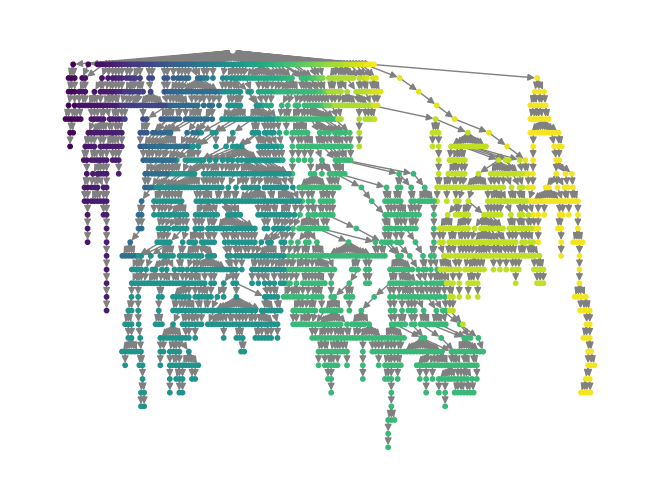

In [7]:
file_path = 'output/bipartite_10/0.1_0.01_tree.txt'
G = build_tree(file_path)

color_map = create_color_map_distance(G, root=0)

pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')  # This positions the nodes using the spring layout
colors = [color_map.get(node, (1, 1, 1)) for node in G.nodes()]

nx.draw(G, pos, node_color=colors, with_labels=False, node_size=10, edge_color='gray')
plt.show()

In [12]:

# Define the list of graphs
graph_options = ["3-r", "5-r", "bipartite_10", "bipartite_30", "bipartite_50", "detour_10", 
                 "detour_30", "detour_50", "detour_70", "detour_90", "geo_0.1", "geo_0.15", 
                 "geo_0.2", "geo_0.25", "PA", "star", "wheel", "wm"]

# Define the list of mu and s values
mus = [0.1, 0.01, 0.001, 0.0001, 0.00001]
ss = [1, 0.1, 0.01, 0.001, 0, -0.001, -0.01, -0.1, -1]

graph_dropdown_1 = widgets.Dropdown(options=graph_options, description='Graph 1:')
mu_slider_1 = widgets.SelectionSlider(options=mus, description='mu 1:')
s_slider_1 = widgets.SelectionSlider(options=ss, description='s 1:')
time_step_slider = widgets.IntSlider(min=0, max=1999, step=1, value=0, description='Time Step')

graph_dropdown_2 = widgets.Dropdown(options=graph_options, description='Graph 2:')
mu_slider_2 = widgets.SelectionSlider(options=mus, description='mu 2:')
s_slider_2 = widgets.SelectionSlider(options=ss, description='s 2:')

color_map_dis = {}


def update_plot_1(graph, mu, s, time_step):
    edge_path = f'graphs/{graph}.txt'
    G = nx.read_edgelist(edge_path, nodetype=int)
    if 'geo' in graph:
        with open(f'graphs/{graph}_nodes.json', 'r') as f:
            pos = json.load(f)
        pos = {int(node): position for node, position in pos.items()}
    else:
        pos = nx.kamada_kawai_layout(G)
    mutations_df = load_mutations(f'output/{graph}/{mu}_{s}_clone.txt')
    tree = build_tree(f'output/{graph}/{mu}_{s}_tree.txt')
    if f"{graph}/{mu}_{s}" not in color_map_dis:
        color_map_dis[f"{graph}/{mu}_{s}"] = create_color_map_distance(tree)
    color_map = color_map_dis[f"{graph}/{mu}_{s}"]
    plot_graph(G, pos, mutations_df, f"{graph} - mu={mu} - s={s}", color_map, time_step)

# Define the function to update graph 2
def update_plot_2(graph, mu, s, time_step):
    edge_path = f'graphs/{graph}.txt'
    G = nx.read_edgelist(edge_path, nodetype=int)
    if 'geo' in graph:
        with open(f'graphs/{graph}_nodes.json', 'r') as f:
            pos = json.load(f)
        pos = {int(node): position for node, position in pos.items()}
    else:
        pos = nx.kamada_kawai_layout(G)
    mutations_df = load_mutations(f'output/{graph}/{mu}_{s}_clone.txt')
    tree = build_tree(f'output/{graph}/{mu}_{s}_tree.txt')
    if f"{graph}/{mu}_{s}" not in color_map_dis:
        color_map_dis[f"{graph}/{mu}_{s}"] = create_color_map_distance(tree)
    color_map = color_map_dis[f"{graph}/{mu}_{s}"]
    plot_graph(G, pos, mutations_df, f"{graph} - mu={mu} - s={s}", color_map, time_step)

# Create the interactive plots
interactive_plot_1 = widgets.interactive(update_plot_1, graph=graph_dropdown_1, mu=mu_slider_1, s=s_slider_1, time_step=time_step_slider)
interactive_plot_2 = widgets.interactive(update_plot_2, graph=graph_dropdown_2, mu=mu_slider_2, s=s_slider_2, time_step=time_step_slider)

# Display the interactive plots side by side
display(widgets.HBox([interactive_plot_1, interactive_plot_2]))

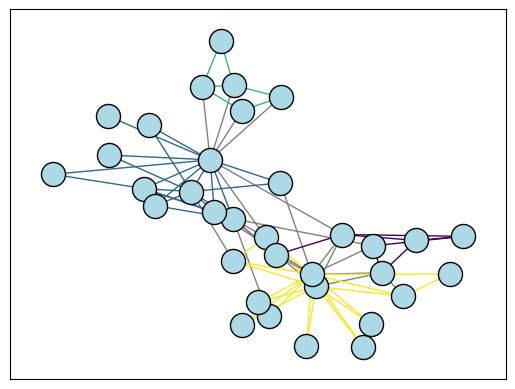

In [9]:
from community import community_louvain
G = nx.karate_club_graph()  # Example graph
partition = community_louvain.best_partition(G)

# Function to get community color
def get_community_color(edge, partition):
    node_start, node_end = edge
    community_start = partition[node_start]
    community_end = partition[node_end]
    if community_start == community_end:
        cmap = plt.get_cmap('viridis')
        return cmap(community_start / max(partition.values()))
    else:
        return 'grey'

# Draw nodes
pos = nx.spring_layout(G, seed=42)  # For consistent layout
nx.draw_networkx_nodes(G, pos, node_color='lightblue', edgecolors='black')

# Draw edges with community-based coloring
edges = G.edges()
colors = [get_community_color(edge, partition) for edge in edges]
nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=colors)

plt.show()

In [10]:
def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def test():
    # to install networkx 2.0 compatible version of python-louvain use:
    # pip install -U git+https://github.com/taynaud/python-louvain.git@networkx2
    from community import community_louvain

    g = nx.karate_club_graph()
    partition = community_louvain.best_partition(g)
    pos = community_layout(g, partition)

    nx.draw(g, pos, node_color=list(partition.values())); plt.show()
    return


In [11]:

# Define the list of graphs
graph_options = ["3-r", "5-r", "bipartite_10", "bipartite_30", "bipartite_50", "detour_10", 
                 "detour_30", "detour_50", "detour_70", "detour_90", "geo_0.1", "geo_0.15", 
                 "geo_0.2", "geo_0.25", "PA", "star", "wheel", "wm"]

# Define the list of mu and s values
mus = [0.1, 0.01, 0.001, 0.0001, 0.00001]
ss = [1, 0.1, 0.01, 0.001, -0.001, -0.01, -0.1, -1]

graph_dropdown_1 = widgets.Dropdown(options=graph_options, description='Graph 1:')
mu_slider_1 = widgets.SelectionSlider(options=mus, description='mu 1:')
s_slider_1 = widgets.SelectionSlider(options=ss, description='s 1:')
time_step_slider = widgets.IntSlider(min=0, max=1999, step=1, value=0, description='Time Step')

graph_dropdown_2 = widgets.Dropdown(options=graph_options, description='Graph 2:')
mu_slider_2 = widgets.SelectionSlider(options=mus, description='mu 2:')
s_slider_2 = widgets.SelectionSlider(options=ss, description='s 2:')

color_map_dis = {}
pos_dic = {}


def update_plot_1(graph, mu, s, time_step):
    edge_path = f'graphs/{graph}.txt'
    G = nx.read_edgelist(edge_path, nodetype=int)
    if f"{graph}" not in pos_dic:
        partition = community_louvain.best_partition(G)
        pos_dic[f"{graph}"] = community_layout(G, partition)
    if 'geo' in graph:
        with open(f'graphs/{graph}_nodes.json', 'r') as f:
            pos = json.load(f)
        pos = {int(node): position for node, position in pos.items()}
    else:
        pos = pos_dic[f"{graph}"]
    mutations_df = load_mutations(f'output/{graph}/{mu}_{s}_clone.txt')
    tree = build_tree(f'output/{graph}/{mu}_{s}_tree.txt')
    if f"{graph}/{mu}_{s}" not in color_map_dis:
        color_map_dis[f"{graph}/{mu}_{s}"] = create_color_map_distance(tree)
    color_map = color_map_dis[f"{graph}/{mu}_{s}"]
    plot_graph(G, pos, mutations_df, f"{graph} - mu={mu} - s={s}", color_map, time_step)

# Define the function to update graph 2
def update_plot_2(graph, mu, s, time_step):
    edge_path = f'graphs/{graph}.txt'
    G = nx.read_edgelist(edge_path, nodetype=int)
    if f"{graph}" not in pos_dic:
        partition = community_louvain.best_partition(G)
        pos_dic[f"{graph}"] = community_layout(G, partition)
    if 'geo' in graph:
        with open(f'graphs/{graph}_nodes.json', 'r') as f:
            pos = json.load(f)
        pos = {int(node): position for node, position in pos.items()}
    else:
        pos = pos_dic[f"{graph}"]
    mutations_df = load_mutations(f'output/{graph}/{mu}_{s}_clone.txt')
    tree = build_tree(f'output/{graph}/{mu}_{s}_tree.txt')
    if f"{graph}/{mu}_{s}" not in color_map_dis:
        color_map_dis[f"{graph}/{mu}_{s}"] = create_color_map_distance(tree)
    color_map = color_map_dis[f"{graph}/{mu}_{s}"]
    plot_graph(G, pos, mutations_df, f"{graph} - mu={mu} - s={s}", color_map, time_step)

# Create the interactive plots
interactive_plot_1 = widgets.interactive(update_plot_1, graph=graph_dropdown_1, mu=mu_slider_1, s=s_slider_1, time_step=time_step_slider)
interactive_plot_2 = widgets.interactive(update_plot_2, graph=graph_dropdown_2, mu=mu_slider_2, s=s_slider_2, time_step=time_step_slider)

# Display the interactive plots side by side
display(widgets.HBox([interactive_plot_1, interactive_plot_2]))